In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from pathlib import Path

In [2]:
DATA_PATH = Path().cwd() / "BTCUSDT"

In [3]:
df = pd.read_pickle(DATA_PATH / "ohlcv_1T.pkl")

def compute_spectral_residual(sequence: np.ndarray) -> np.ndarray:
    f, t, Zxx = signal.stft(sequence, fs=60)
    magnitude = np.abs(Zxx)
    spectral_residual = np.exp(np.log(magnitude) - np.log(np.mean(magnitude)))

    Zxx.real *= spectral_residual / magnitude
    Zxx.imag *= spectral_residual / magnitude

    silency_map = signal.istft(Zxx, fs=60)[1]
    spectral_residual = np.abs(silency_map)[:len(sequence)]

    # calculate the score
    anomaly_score = stats.chi2.pdf((spectral_residual - np.mean(spectral_residual)) ** 2 / np.var(spectral_residual), df=1)

    return anomaly_score

price = df["Close"].values
anomaly_score = compute_spectral_residual(df["Close"].values)
threshold = np.mean(anomaly_score) + 3 * np.std(anomaly_score)
anomaly_detected = np.where(anomaly_score > threshold, 1, 0)
df["anomaly_score"] = anomaly_score
df["anoamly_detected"] = anomaly_detected
df.describe()

,Open,High,Low,Close,Volume,Buy volume,Sell volume,anomaly_score,anoamly_detected
count,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06
mean,3.779540e+04,3.781268e+04,3.777810e+04,3.779528e+04,6.487774e+01,3.238970e+01,3.248805e+01,4.053019e+00,8.009893e-04
std,1.385733e+04,1.386220e+04,1.385232e+04,1.385740e+04,1.804997e+02,9.579268e+01,9.815623e+01,1.480395e+02,2.829043e-02
min,1.548903e+04,1.552445e+04,1.545653e+04,1.548777e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.378053e-02,0.000000e+00
25%,2.313800e+04,2.314650e+04,2.313000e+04,2.313812e+04,1.010400e+01,3.178000e+00,3.207000e+00,1.260883e-01,0.000000e+00
50%,3.871800e+04,3.874000e+04,3.869750e+04,3.871800e+04,2.499800e+01,1.045400e+01,1.055000e+01,3.634670e-01,0.000000e+00
75%,4.791100e+04,4.792950e+04,4.789050e+04,4.791109e+04,6.117000e+01,2.979900e+01,2.997100e+01,1.098231e+00,0.000000e+00
max,6.910151e+04,6.912050e+04,6.884250e+04,6.909450e+04,2.702585e+04,1.294854e+04,1.630684e+04,2.544490e+04,1.000000e+00


In [7]:
print(f"Anomaly detected: {np.sum(anomaly_detected)}/{len(anomaly_detected)} ({np.sum(anomaly_detected) / len(anomaly_detected) * 100:.2f}%)")

Anomaly detected: 842/1051200 (0.08%)


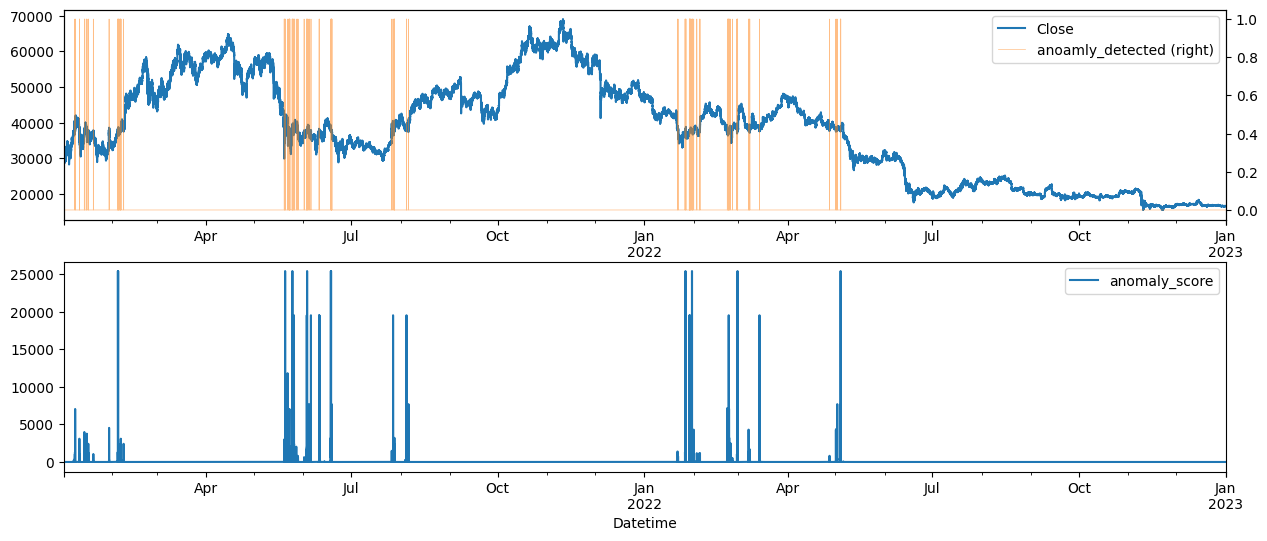

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
df.plot(y="Close", ax=axes[0])
df.plot(y="anoamly_detected", ax=axes[0], secondary_y=True, alpha=0.5, linewidth=0.5)
df.plot(y="anomaly_score", ax=axes[1])
plt.show()